# Лекция №10

## На прошлой лекции

[dynamicMotionSolverFvMesh](#motion)

[Конвекция](#conv)

[Градиент](#grad)

## План
1. [Конвекция OpenFOAM](#convection_of)
2. [Нелинейность](#nonlinear)

## Метод контрольного объема (Finite Volume Method) <a name="FVM"></a>

<img src="img/finite_volume.png" width="1000" height="200">

Уравнение переноса в интегральной форме:

$$
\int_V {\partial{\rho \phi}\over {\partial t}} dV + \int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV = \int_V \nabla \cdot \left(\Gamma \nabla \phi \right) dV + \int_V S_\phi dV
$$

$dV$ - элементарный объем (ячейка сетки) "картинка ячейки"

$\phi$ - объемное поле (volScalarField) ($\rho,\rho U,\rho E, T$)

$\vec U$ - объемное поле скорости

$\rho$ - объемное поле плотности

$\Gamma$ - объемное поле коэффициента диффузии

$S_\phi$ - объемное поле источника

<img src="img/cell.png" width="300" height="200">

[FVM wolfdynamics](../books/wd_fvm.pdf) p.12

[ProgrammerGuide](../books/OFpg.pdf) p.25

Производная по времени:

$$\int_V {\partial{\rho \phi}\over {\partial t}} dV \approx ({\partial{\rho \phi}\over {\partial t}})_P V_p$$

Источник:
$$\int_V S_\phi dV \approx S_{\phi P} V_P$$

Источник и производная по времени: только объемные поля (volScalarField), нет связи с соседними ячейками

Теорема Остроградского-Гаусса:

$$\int_V \left( \nabla \cdot \vec u \right) dV = \oint_S \left( \vec{n} \cdot \vec u \right) dS \approx
\sum\limits_{face} \left( \vec{n} \cdot \vec u \right)_f S_f
$$

Конвекция:

$$\int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV \approx
\sum\limits_{face} \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

Диффузия:

$$\int_V \nabla \cdot \left(\Gamma \nabla \phi \right) dV \approx
\sum\limits_{face} \left(\Gamma \nabla \phi  \cdot \vec{n} \right)_f S_f$$

Конвекция и диффузия: поля на гранях (surfaceScalarField), связь с соседними ячейками

## Конвекция OpenFOAM <a name="convection_of"></a> 

<img src="img/cell.png" width="300" height="200">
$P$ - центр владельца, $N$ - центр соседа

Неявная схема: $Q = Q^{n+1}, \phi =\phi^{n+1}$ 
$$\nabla Q_f = \underbrace{\alpha \frac{Q_P - Q_N}{| \vec{d} |}}_{\mathrm{implicit}} + \underbrace{\left( \hat{\vec{n}} - \alpha \hat{\vec{d}} \right) \cdot \left( \nabla Q \right)_f}_{\mathrm{explicit\ correction}}$$

$\alpha_f / |\vec{d}|$ - одинаковый и на диагональ и вне, симметричная матрица

$$div (\rho \phi \vec{U})_C V_C \approx \int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV \approx
\sum\limits_{face} \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

$$\left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

$\vec U_f$ - предполагаем, что известно (линейная интерполяция), $\phi$ зависит от схемы аппроксимации:

$$\phi_f = \beta_P \phi_P + \beta_N \phi_N$$

upwind - в зависимости от знака $\vec U_f \cdot \vec n_f$ 

$\beta_P = 0, \beta_N = 1$ или 

$\beta_P = 1, \beta_N = 0$ 

нессиметричная матрица!

$\vec U_f \cdot \vec n_f \rho_fS_f$ - коэффициент на диагональ > 0

Коэффициент на диагонали больше или равен нулю, что хорошо для СЛАУ, но низкий порядок точности! (только для upwind!)

<img src="img/mesh_slau.png" width="500" height="200">

linear - линейная интерполяция не учитывает знак $\vec U_f \cdot \vec n_f$ 

$\beta_P = \Delta Pf / PN, \beta_N = \Delta Nf / PN $ 

$\vec U_f \cdot \vec n_f \rho_fS_f$ - коэффициент на диагональ может быть отрицательный, если направление скорости направлено против нормали грани!

Плохо для СЛАУ, но высокий порядок точности! (для стационарных задач решается релаксацией, но лучше делать по-другому)

#### Как неявно и с высоким порядком аппроксимировать конвективный член?

### Метод Ньютона!

$$F_f = \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

$$F_f^{n+1}(\phi) = F_f^{n} + \frac{\partial F_f}{\partial \phi} (\phi^{n+1} - \phi^n)$$

или для стационарных задач $\lim_{n \to \infty} \phi^{n+1} \approx \phi^{n} $

$$F_f^{n+1}(\phi) = F_{f2}^{n} + F_{f1}^{n+1}-F_{f1}^{n}$$

где $F_{fk}, k$ - порядок точности, 2 - linear, 1 - upwind

```c++
 fvc::div(phi, T, "2ord")
+fvm::div(phi, T, "1ord_im")
-fvc::div(phi, T, "1ord_ex")
```

fvSchemes
```c++
 divSchemes
{
    default         none;
    2ord        Gauss vanAlbada; //linear; linearUpwind gradT
    1ord_im     Gauss upwind; 
    1ord_ex     Gauss upwind; 
}
```

In [ ]:
#!cat $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/convectionSchemes/gaussConvectionScheme/gaussConvectionScheme.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2016 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

\*---------------------------------------------------------------------------*/

#include "gaussConvectionScheme.H"
#include "fvcSurfaceIntegrate.H"
#include "fvMatrices.H"

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

namespace Foam
{

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

namespace fv
{

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

template<class Type>
const surfaceInterpolationScheme<Type>&
gaussConvectionScheme<Type>::interpScheme() const
{
    return tinterpScheme_();
}


template<class Type>
tmp<GeometricField<Type, fvsPatchField, surfaceMesh>>
gaussConvectionScheme<Type>::interpolate
(
    const surfaceScalarField&,
    const GeometricField<Type, fvPatchField, volMesh>& vf
) const
{
    return tinterpScheme_().interpolate(vf);
}


template<class Type>
tmp<GeometricField<Type, fvsPatchField, surfaceMesh>>
gaussConvectionScheme<Type>::flux
(
    const surfaceScalarField& faceFlux,
    const GeometricField<Type, fvPatchField, volMesh>& vf
) const
{
    return faceFlux*interpolate(faceFlux, vf);
}


template<class Type>
tmp<fvMatrix<Type>>
gaussConvectionScheme<Type>::fvmDiv
(
    const surfaceScalarField& faceFlux,
    const GeometricField<Type, fvPatchField, volMesh>& vf
) const
{
    tmp<surfaceScalarField> tweights = tinterpScheme_().weights(vf);
    const surfaceScalarField& weights = tweights();

    tmp<fvMatrix<Type>> tfvm
    (
        new fvMatrix<Type>
        (
            vf,
            faceFlux.dimensions()*vf.dimensions()
        )
    );
    fvMatrix<Type>& fvm = tfvm.ref();

    fvm.lower() = -weights.primitiveField()*faceFlux.primitiveField();
    fvm.upper() = fvm.lower() + faceFlux.primitiveField();
    fvm.negSumDiag();

    forAll(vf.boundaryField(), patchi)
    {
        const fvPatchField<Type>& psf = vf.boundaryField()[patchi];
        const fvsPatchScalarField& patchFlux = faceFlux.boundaryField()[patchi];
        const fvsPatchScalarField& pw = weights.boundaryField()[patchi];

        fvm.internalCoeffs()[patchi] = patchFlux*psf.valueInternalCoeffs(pw);
        fvm.boundaryCoeffs()[patchi] = -patchFlux*psf.valueBoundaryCoeffs(pw);
    }

    if (tinterpScheme_().corrected())
    {
        fvm += fvc::surfaceIntegrate(faceFlux*tinterpScheme_().correction(vf));
    }

    return tfvm;
}


template<class Type>
tmp<GeometricField<Type, fvPatchField, volMesh>>
gaussConvectionScheme<Type>::fvcDiv
(
    const surfaceScalarField& faceFlux,
    const GeometricField<Type, fvPatchField, volMesh>& vf
) const
{
    tmp<GeometricField<Type, fvPatchField, volMesh>> tConvection
    (
        fvc::surfaceIntegrate(flux(faceFlux, vf))
    );

    tConvection.ref().rename
    (
        "convection(" + faceFlux.name() + ',' + vf.name() + ')'
    );

    return tConvection;
}


// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

} // End namespace fv

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

} // End namespace Foam

// ************************************************************************* //
```

In [ ]:
# scalarTransportFoam - солвер для решения уравнения переноса
#!cat $WM_PROJECT_DIR/applications/solvers/basic/scalarTransportFoam/scalarTransportFoam.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2017 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    scalarTransportFoam

Group
    grpBasicSolvers

Description
    Passive scalar transport equation solver.

    \heading Solver details
    The equation is given by:

    \f[
        \ddt{T} + \div \left(\vec{U} T\right) - \div \left(D_T \grad T \right)
        = S_{T}
    \f]

    Where:
    \vartable
        T       | Passive scalar
        D_T     | Diffusion coefficient
        S_T     | Source
    \endvartable

    \heading Required fields
    \plaintable
        T       | Passive scalar
        U       | Velocity [m/s]
    \endplaintable

\*---------------------------------------------------------------------------*/

#include "fvCFD.H"
#include "fvOptions.H"
#include "simpleControl.H"

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Passive scalar transport equation solver."
    );

    #include "addCheckCaseOptions.H"
    #include "setRootCaseLists.H"
    #include "createTime.H"
    #include "createMesh.H"

    simpleControl simple(mesh);

    #include "createFields.H"

    // * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

    Info<< "\nCalculating scalar transport\n" << endl;

    #include "CourantNo.H"

    while (simple.loop())
    {
        Info<< "Time = " << runTime.timeName() << nl << endl;

        while (simple.correctNonOrthogonal())
        {
            fvScalarMatrix TEqn
            (
                fvm::ddt(T)
              + fvm::div(phi, T)
              - fvm::laplacian(DT, T)
             ==
                fvOptions(T)
            );

            TEqn.relax();
            fvOptions.constrain(TEqn);
            TEqn.solve();
            fvOptions.correct(T);
        }

        runTime.write();
    }

    Info<< "End\n" << endl;

    return 0;
}


// ************************************************************************* //
```

In [1]:
!cat $WM_PROJECT_DIR/applications/solvers/basic/scalarTransportFoam/createFields.H

Info<< "Reading field T\n" << endl;

volScalarField T
(
    IOobject
    (
        "T",
        runTime.timeName(),
        mesh,
        IOobject::MUST_READ,
        IOobject::AUTO_WRITE
    ),
    mesh
);


Info<< "Reading field U\n" << endl;

volVectorField U
(
    IOobject
    (
        "U",
        runTime.timeName(),
        mesh,
        IOobject::MUST_READ,
        IOobject::AUTO_WRITE
    ),
    mesh
);


Info<< "Reading transportProperties\n" << endl;

IOdictionary transportProperties
(
    IOobject
    (
        "transportProperties",
        runTime.constant(),
        mesh,
        IOobject::MUST_READ_IF_MODIFIED,
        IOobject::NO_WRITE
    )
);


Info<< "Reading diffusivity DT\n" << endl;

dimensionedScalar DT("DT", dimViscosity, transportProperties);

#include "createPhi.H"

#include "createFvOptions.H"


[createPhi.H doxygen](https://www.openfoam.com/documentation/guides/latest/api/src_2finiteVolume_2cfdTools_2incompressible_2createPhi_8H_source.html)

[fvc::flux doxygen](https://www.openfoam.com/documentation/guides/latest/api/fvcFlux_8C_source.html)

## Пример


In [2]:
ls pitzDaily/

0/  constant/  geom.png  mesh.png  result.mp4  system/  u.png


In [3]:
!cat pitzDaily/constant/transportProperties

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "constant";
    object      transportProperties;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

DT              0.01;


// ************************************************************************* //


In [4]:
#blockMeshDict
!ls pitzDaily/system

blockMeshDict  controlDict  fvSchemes  fvSolution


<img src="pitzDaily/geom.png" width="500" height="200">
<img src="pitzDaily/mesh.png" width="500" height="200">

In [5]:
!ls pitzDaily/0

T  U


In [6]:
!cat pitzDaily/0/U

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       volVectorField;
    location    "288";
    object      U;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dimensions      [0 1 -1 0 0 0 0];

internalField   nonuniform List<vector>
12225
(
(9.85698 -0.886449 0)
(9.66665 -0.740747 0)
(9.45574 -0.429483 0)
(9.22457 -0.222216 0)
(9.00656 -0.106462 0)
(8.81447 -0.0458767 0)
(8.64764 -0.

<img src="pitzDaily/u.png" width="800" height="200">

In [7]:
!cat pitzDaily/0/T

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    object      T;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dimensions      [0 0 0 1 0 0 0];

internalField   uniform 0;

boundaryField
{
    inlet
    {
        type            fixedValue;
        value           uniform 1;
    }

    outlet
    {
        type            zeroGradient;
    }

    upperWall
   

In [8]:
!cat pitzDaily/system/fvSchemes

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSchemes;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

ddtSchemes
{
    default         Euler;
}

gradSchemes
{
    default         Gauss linear;
}

divSchemes
{
    default         none;
    div(phi,T)      Gauss linearUpwind grad(T);
}

laplacianSchemes
{
    default       

In [9]:
!cat pitzDaily/system/fvSolution

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSolution;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

solvers
{
    T
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1e-06;
        relTol          0;
    }
}

SIMPLE
{
    nNonOrthogonalCorrectors 0;
}


// ******************

In [10]:
!cat pitzDaily/system/controlDict

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      controlDict;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

application     scalarTransportFoam;

startFrom       startTime;

startTime       0;

stopAt          endTime;

endTime         0.1;

deltaT          0.0001;

writeControl    timeStep;

writeInterval   50;

purgeWrite  

In [11]:
!scalarTransportFoam -case pitzDaily

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : _7bdb509494-20201222 OPENFOAM=2012
Arch   : "LSB;label=32;scalar=64"
Exec   : scalarTransportFoam -case pitzDaily
Date   : Dec 04 2021
Time   : 13:11:27
Host   : kuvv-PS63-Modern-8M
PID    : 21387
I/O    : uncollated
Case   : /home/kuvv/work/Projects/phystech_lectures/lecture_10/pitzDaily
nProcs : 1
trapFpe: Floating point exception trapping enabled (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files us

DILUPBiCGStab:  Solving for T, Initial residual = 0.00382287, Final residual = 5.31163e-07, No Iterations 4
Time = 0.0059

DILUPBiCGStab:  Solving for T, Initial residual = 0.00377288, Final residual = 5.08674e-07, No Iterations 4
Time = 0.006

DILUPBiCGStab:  Solving for T, Initial residual = 0.0037249, Final residual = 9.75343e-07, No Iterations 4
Time = 0.0061

DILUPBiCGStab:  Solving for T, Initial residual = 0.00367882, Final residual = 9.35196e-07, No Iterations 4
Time = 0.0062

DILUPBiCGStab:  Solving for T, Initial residual = 0.00363454, Final residual = 8.97664e-07, No Iterations 4
Time = 0.0063

DILUPBiCGStab:  Solving for T, Initial residual = 0.00359194, Final residual = 8.62304e-07, No Iterations 4
Time = 0.0064

DILUPBiCGStab:  Solving for T, Initial residual = 0.00355095, Final residual = 8.28923e-07, No Iterations 4
Time = 0.0065

DILUPBiCGStab:  Solving for T, Initial residual = 0.00351148, Final residual = 7.97407e-07, No Iterations 4
Time = 0.0066

DILUPBiCGStab:  So

DILUPBiCGStab:  Solving for T, Initial residual = 0.00245767, Final residual = 4.918e-07, No Iterations 3
Time = 0.0128

DILUPBiCGStab:  Solving for T, Initial residual = 0.00245154, Final residual = 4.84271e-07, No Iterations 3
Time = 0.0129

DILUPBiCGStab:  Solving for T, Initial residual = 0.00244557, Final residual = 4.76944e-07, No Iterations 3
Time = 0.013

DILUPBiCGStab:  Solving for T, Initial residual = 0.0024398, Final residual = 4.69819e-07, No Iterations 3
Time = 0.0131

DILUPBiCGStab:  Solving for T, Initial residual = 0.00243417, Final residual = 4.62882e-07, No Iterations 3
Time = 0.0132

DILUPBiCGStab:  Solving for T, Initial residual = 0.00242872, Final residual = 4.5613e-07, No Iterations 3
Time = 0.0133

DILUPBiCGStab:  Solving for T, Initial residual = 0.00242343, Final residual = 4.49561e-07, No Iterations 3
Time = 0.0134

DILUPBiCGStab:  Solving for T, Initial residual = 0.00241829, Final residual = 4.43168e-07, No Iterations 3
Time = 0.0135

DILUPBiCGStab:  Solvi

DILUPBiCGStab:  Solving for T, Initial residual = 0.00232281, Final residual = 7.48189e-07, No Iterations 3
Time = 0.0195

DILUPBiCGStab:  Solving for T, Initial residual = 0.00232396, Final residual = 7.445e-07, No Iterations 3
Time = 0.0196

DILUPBiCGStab:  Solving for T, Initial residual = 0.00232519, Final residual = 7.40913e-07, No Iterations 3
Time = 0.0197

DILUPBiCGStab:  Solving for T, Initial residual = 0.0023265, Final residual = 7.37433e-07, No Iterations 3
Time = 0.0198

DILUPBiCGStab:  Solving for T, Initial residual = 0.00232787, Final residual = 7.34059e-07, No Iterations 3
Time = 0.0199

DILUPBiCGStab:  Solving for T, Initial residual = 0.00232932, Final residual = 7.30794e-07, No Iterations 3
Time = 0.02

DILUPBiCGStab:  Solving for T, Initial residual = 0.00233085, Final residual = 7.27642e-07, No Iterations 3
Time = 0.0201

DILUPBiCGStab:  Solving for T, Initial residual = 0.00233245, Final residual = 7.24603e-07, No Iterations 3
Time = 0.0202

DILUPBiCGStab:  Solvi

DILUPBiCGStab:  Solving for T, Initial residual = 0.00257207, Final residual = 7.43912e-07, No Iterations 3
Time = 0.0264

DILUPBiCGStab:  Solving for T, Initial residual = 0.00257823, Final residual = 7.4557e-07, No Iterations 3
Time = 0.0265

DILUPBiCGStab:  Solving for T, Initial residual = 0.00258444, Final residual = 7.47196e-07, No Iterations 3
Time = 0.0266

DILUPBiCGStab:  Solving for T, Initial residual = 0.00259073, Final residual = 7.48799e-07, No Iterations 3
Time = 0.0267

DILUPBiCGStab:  Solving for T, Initial residual = 0.0025971, Final residual = 7.50377e-07, No Iterations 3
Time = 0.0268

DILUPBiCGStab:  Solving for T, Initial residual = 0.00260354, Final residual = 7.51925e-07, No Iterations 3
Time = 0.0269

DILUPBiCGStab:  Solving for T, Initial residual = 0.00261002, Final residual = 7.53443e-07, No Iterations 3
Time = 0.027

DILUPBiCGStab:  Solving for T, Initial residual = 0.00261658, Final residual = 7.54935e-07, No Iterations 3
Time = 0.0271

DILUPBiCGStab:  Sol

DILUPBiCGStab:  Solving for T, Initial residual = 0.00301501, Final residual = 8.11824e-07, No Iterations 3
Time = 0.0331

DILUPBiCGStab:  Solving for T, Initial residual = 0.00301858, Final residual = 8.12667e-07, No Iterations 3
Time = 0.0332

DILUPBiCGStab:  Solving for T, Initial residual = 0.00302193, Final residual = 8.13513e-07, No Iterations 3
Time = 0.0333

DILUPBiCGStab:  Solving for T, Initial residual = 0.00302505, Final residual = 8.14358e-07, No Iterations 3
Time = 0.0334

DILUPBiCGStab:  Solving for T, Initial residual = 0.00302791, Final residual = 8.152e-07, No Iterations 3
Time = 0.0335

DILUPBiCGStab:  Solving for T, Initial residual = 0.00303054, Final residual = 8.16049e-07, No Iterations 3
Time = 0.0336

DILUPBiCGStab:  Solving for T, Initial residual = 0.00303293, Final residual = 8.16907e-07, No Iterations 3
Time = 0.0337

DILUPBiCGStab:  Solving for T, Initial residual = 0.00303508, Final residual = 8.17775e-07, No Iterations 3
Time = 0.0338

DILUPBiCGStab:  So

DILUPBiCGStab:  Solving for T, Initial residual = 0.00272833, Final residual = 8.96059e-07, No Iterations 3
Time = 0.0398

DILUPBiCGStab:  Solving for T, Initial residual = 0.00271863, Final residual = 8.97501e-07, No Iterations 3
Time = 0.0399

DILUPBiCGStab:  Solving for T, Initial residual = 0.00270891, Final residual = 8.98938e-07, No Iterations 3
Time = 0.04

DILUPBiCGStab:  Solving for T, Initial residual = 0.00269919, Final residual = 9.0037e-07, No Iterations 3
Time = 0.0401

DILUPBiCGStab:  Solving for T, Initial residual = 0.00268947, Final residual = 9.01795e-07, No Iterations 3
Time = 0.0402

DILUPBiCGStab:  Solving for T, Initial residual = 0.00267976, Final residual = 9.03213e-07, No Iterations 3
Time = 0.0403

DILUPBiCGStab:  Solving for T, Initial residual = 0.00267006, Final residual = 9.04626e-07, No Iterations 3
Time = 0.0404

DILUPBiCGStab:  Solving for T, Initial residual = 0.00266038, Final residual = 9.0603e-07, No Iterations 3
Time = 0.0405

DILUPBiCGStab:  Solv

DILUPBiCGStab:  Solving for T, Initial residual = 0.00220919, Final residual = 9.7241e-07, No Iterations 3
Time = 0.0468

DILUPBiCGStab:  Solving for T, Initial residual = 0.00220508, Final residual = 9.73171e-07, No Iterations 3
Time = 0.0469

DILUPBiCGStab:  Solving for T, Initial residual = 0.00220106, Final residual = 9.73928e-07, No Iterations 3
Time = 0.047

DILUPBiCGStab:  Solving for T, Initial residual = 0.00219711, Final residual = 9.74677e-07, No Iterations 3
Time = 0.0471

DILUPBiCGStab:  Solving for T, Initial residual = 0.00219324, Final residual = 9.75421e-07, No Iterations 3
Time = 0.0472

DILUPBiCGStab:  Solving for T, Initial residual = 0.00218945, Final residual = 9.7616e-07, No Iterations 3
Time = 0.0473

DILUPBiCGStab:  Solving for T, Initial residual = 0.00218573, Final residual = 9.76894e-07, No Iterations 3
Time = 0.0474

DILUPBiCGStab:  Solving for T, Initial residual = 0.00218209, Final residual = 9.77623e-07, No Iterations 3
Time = 0.0475

DILUPBiCGStab:  Sol

DILUPBiCGStab:  Solving for T, Initial residual = 0.0020487, Final residual = 4.64976e-07, No Iterations 3
Time = 0.0538

DILUPBiCGStab:  Solving for T, Initial residual = 0.00204752, Final residual = 4.65234e-07, No Iterations 3
Time = 0.0539

DILUPBiCGStab:  Solving for T, Initial residual = 0.00204636, Final residual = 4.65494e-07, No Iterations 3
Time = 0.054

DILUPBiCGStab:  Solving for T, Initial residual = 0.00204521, Final residual = 4.65756e-07, No Iterations 3
Time = 0.0541

DILUPBiCGStab:  Solving for T, Initial residual = 0.00204407, Final residual = 4.66021e-07, No Iterations 3
Time = 0.0542

DILUPBiCGStab:  Solving for T, Initial residual = 0.00204296, Final residual = 4.66287e-07, No Iterations 3
Time = 0.0543

DILUPBiCGStab:  Solving for T, Initial residual = 0.00204185, Final residual = 4.66556e-07, No Iterations 3
Time = 0.0544

DILUPBiCGStab:  Solving for T, Initial residual = 0.00204076, Final residual = 4.66826e-07, No Iterations 3
Time = 0.0545

DILUPBiCGStab:  So

DILUPBiCGStab:  Solving for T, Initial residual = 0.00199379, Final residual = 4.84568e-07, No Iterations 3
Time = 0.0606

DILUPBiCGStab:  Solving for T, Initial residual = 0.00199324, Final residual = 4.84861e-07, No Iterations 3
Time = 0.0607

DILUPBiCGStab:  Solving for T, Initial residual = 0.00199269, Final residual = 4.85153e-07, No Iterations 3
Time = 0.0608

DILUPBiCGStab:  Solving for T, Initial residual = 0.00199215, Final residual = 4.85445e-07, No Iterations 3
Time = 0.0609

DILUPBiCGStab:  Solving for T, Initial residual = 0.00199161, Final residual = 4.85737e-07, No Iterations 3
Time = 0.061

DILUPBiCGStab:  Solving for T, Initial residual = 0.00199108, Final residual = 4.86029e-07, No Iterations 3
Time = 0.0611

DILUPBiCGStab:  Solving for T, Initial residual = 0.00199055, Final residual = 4.8632e-07, No Iterations 3
Time = 0.0612

DILUPBiCGStab:  Solving for T, Initial residual = 0.00199003, Final residual = 4.86611e-07, No Iterations 3
Time = 0.0613

DILUPBiCGStab:  So

DILUPBiCGStab:  Solving for T, Initial residual = 0.00196515, Final residual = 5.03433e-07, No Iterations 3
Time = 0.0673

DILUPBiCGStab:  Solving for T, Initial residual = 0.00196482, Final residual = 5.03701e-07, No Iterations 3
Time = 0.0674

DILUPBiCGStab:  Solving for T, Initial residual = 0.0019645, Final residual = 5.03968e-07, No Iterations 3
Time = 0.0675

DILUPBiCGStab:  Solving for T, Initial residual = 0.00196417, Final residual = 5.04235e-07, No Iterations 3
Time = 0.0676

DILUPBiCGStab:  Solving for T, Initial residual = 0.00196385, Final residual = 5.04502e-07, No Iterations 3
Time = 0.0677

DILUPBiCGStab:  Solving for T, Initial residual = 0.00196353, Final residual = 5.04768e-07, No Iterations 3
Time = 0.0678

DILUPBiCGStab:  Solving for T, Initial residual = 0.00196321, Final residual = 5.05034e-07, No Iterations 3
Time = 0.0679

DILUPBiCGStab:  Solving for T, Initial residual = 0.00196289, Final residual = 5.05299e-07, No Iterations 3
Time = 0.068

DILUPBiCGStab:  So

DILUPBiCGStab:  Solving for T, Initial residual = 0.00194678, Final residual = 5.20843e-07, No Iterations 3
Time = 0.0742

DILUPBiCGStab:  Solving for T, Initial residual = 0.00194657, Final residual = 5.21079e-07, No Iterations 3
Time = 0.0743

DILUPBiCGStab:  Solving for T, Initial residual = 0.00194636, Final residual = 5.21314e-07, No Iterations 3
Time = 0.0744

DILUPBiCGStab:  Solving for T, Initial residual = 0.00194615, Final residual = 5.21549e-07, No Iterations 3
Time = 0.0745

DILUPBiCGStab:  Solving for T, Initial residual = 0.00194594, Final residual = 5.21783e-07, No Iterations 3
Time = 0.0746

DILUPBiCGStab:  Solving for T, Initial residual = 0.00194573, Final residual = 5.22017e-07, No Iterations 3
Time = 0.0747

DILUPBiCGStab:  Solving for T, Initial residual = 0.00194553, Final residual = 5.22251e-07, No Iterations 3
Time = 0.0748

DILUPBiCGStab:  Solving for T, Initial residual = 0.00194532, Final residual = 5.22484e-07, No Iterations 3
Time = 0.0749

DILUPBiCGStab:  

DILUPBiCGStab:  Solving for T, Initial residual = 0.00193499, Final residual = 5.35597e-07, No Iterations 3
Time = 0.0809

DILUPBiCGStab:  Solving for T, Initial residual = 0.00193484, Final residual = 5.35801e-07, No Iterations 3
Time = 0.081

DILUPBiCGStab:  Solving for T, Initial residual = 0.0019347, Final residual = 5.36005e-07, No Iterations 3
Time = 0.0811

DILUPBiCGStab:  Solving for T, Initial residual = 0.00193456, Final residual = 5.36209e-07, No Iterations 3
Time = 0.0812

DILUPBiCGStab:  Solving for T, Initial residual = 0.00193442, Final residual = 5.36412e-07, No Iterations 3
Time = 0.0813

DILUPBiCGStab:  Solving for T, Initial residual = 0.00193428, Final residual = 5.36614e-07, No Iterations 3
Time = 0.0814

DILUPBiCGStab:  Solving for T, Initial residual = 0.00193414, Final residual = 5.36817e-07, No Iterations 3
Time = 0.0815

DILUPBiCGStab:  Solving for T, Initial residual = 0.001934, Final residual = 5.37018e-07, No Iterations 3
Time = 0.0816

DILUPBiCGStab:  Solv

DILUPBiCGStab:  Solving for T, Initial residual = 0.0019267, Final residual = 5.48832e-07, No Iterations 3
Time = 0.0879

DILUPBiCGStab:  Solving for T, Initial residual = 0.0019266, Final residual = 5.49006e-07, No Iterations 3
Time = 0.088

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192651, Final residual = 5.49179e-07, No Iterations 3
Time = 0.0881

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192641, Final residual = 5.49352e-07, No Iterations 3
Time = 0.0882

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192632, Final residual = 5.49524e-07, No Iterations 3
Time = 0.0883

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192623, Final residual = 5.49696e-07, No Iterations 3
Time = 0.0884

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192613, Final residual = 5.49868e-07, No Iterations 3
Time = 0.0885

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192604, Final residual = 5.50039e-07, No Iterations 3
Time = 0.0886

DILUPBiCGStab:  Sol

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192128, Final residual = 5.60018e-07, No Iterations 3
Time = 0.0949

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192122, Final residual = 5.60164e-07, No Iterations 3
Time = 0.095

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192116, Final residual = 5.6031e-07, No Iterations 3
Time = 0.0951

DILUPBiCGStab:  Solving for T, Initial residual = 0.0019211, Final residual = 5.60455e-07, No Iterations 3
Time = 0.0952

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192104, Final residual = 5.606e-07, No Iterations 3
Time = 0.0953

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192098, Final residual = 5.60744e-07, No Iterations 3
Time = 0.0954

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192092, Final residual = 5.60889e-07, No Iterations 3
Time = 0.0955

DILUPBiCGStab:  Solving for T, Initial residual = 0.00192087, Final residual = 5.61032e-07, No Iterations 3
Time = 0.0956

DILUPBiCGStab:  Solvi

In [12]:
%%HTML
<video width="1080" height="720" controls>
  <source src="pitzDaily/result.mp4" type="video/mp4">
</video>

## Резюме:

$$
\int_V {\partial{\rho T}\over {\partial t}} dV + \int_V \nabla \cdot \left(\rho T \vec{U} \right) dV = \int_V \nabla \cdot \left(\Gamma \nabla T \right) dV + \int_V S_T dV
$$

```c++
fvScalarMatrix TEqn
    (
        fvm::ddt(rho, T)
      + fvm::div(rho_f*phi, T)
     ==
        fvm::laplacian(rho*DT, T)
      + fvm::SuSp(S,T)
    );
```

<img src="img/fvSchemes.png" width="500" height="200">

## Нелинейность <a name="nonlinear"></a>
$$\int_V {\partial{\rho T}\over {\partial t}} dV + \int_V \nabla \cdot \left(\rho T \vec{U} \right) dV = \int_V \nabla \cdot \left(\Gamma \nabla T \right) dV + \int_V S_T dV$$

а что если $\vec U, \Gamma, S = f(T) $ ?

### Диффузия

[F. Moukalled; L. Mangani; M. Darwish](../books/darwish.pdf) p 224 (249)

[Патанкар](../books/patankar.pdf) p 41 (39)

$\Gamma = f(T) $ или резко меняется (интерфейс между различными средами: воздух - металл).

### Интерфейс воздух - металл

$q_f = (\Gamma \nabla T)_f ?$

Рассмострим 2е ячейки

<img src="img/cell.png" width="300" height="200">
$P$ - центр владельца, $N$ - центр соседа

для двух случаев: $\Gamma_P \to 0 $ и $\Gamma_P >> \Gamma_N$

$\Gamma_f(\Gamma_P,\Gamma_N)?$

Среднее арифметическое (linear) или среднее гармоническое (harmonic)?

$f_e = |\vec Pf|/|\vec PN|$

linear: $\Gamma_f = f_e \Gamma_P + (1-f_e)\Gamma_N$

harmonic: $\Gamma_f = (f_e / \Gamma_P + (1-f_e) / \Gamma_N)^{-1}$

Пусть $f_e = 1/2$, тогда

linear: $\Gamma_f =  \frac{\Gamma_P + \Gamma_N}{2}$

harmonic: $\Gamma_f = \frac{2\Gamma_P  \Gamma_N}{\Gamma_P + \Gamma_N}$

В случае $\Gamma_P \to 0 $ тепло не проводится совсем

linear: $\Gamma_f =  \frac{\Gamma_N}{2}$ и $q_f \neq 0$

harmonic: $\Gamma_f = 0$ и $q_f = 0$

В случае $\Gamma_P >> \Gamma_N$ 

linear: $\Gamma_f =  \frac{\Gamma_P}{2}$

harmonic: $\Gamma_f = 2\Gamma_N$

Важно! В обоих случаях $\Gamma_f$ не зависит от высокопроводящей среды при гармоническом среднем.

Лучше использовать harmonic! или мельчить сетку и linear.

Как влияет на свойство СЛАУ?

### Нелинейность

Если $\Gamma = \Gamma(T)$

В арсенале есть только СЛАУ, умеем решать только линейные уравнения.

Итерационный процесс (подцикл) решения задачи на единичном шаге по времени.

Пересчет $\Gamma$ для нового значения $T$

### Конвекция

Модельное уравнение Бюргерса: 
$${\partial{u}\over {\partial t}}+u{\partial{u}\over {\partial x}}=0$$

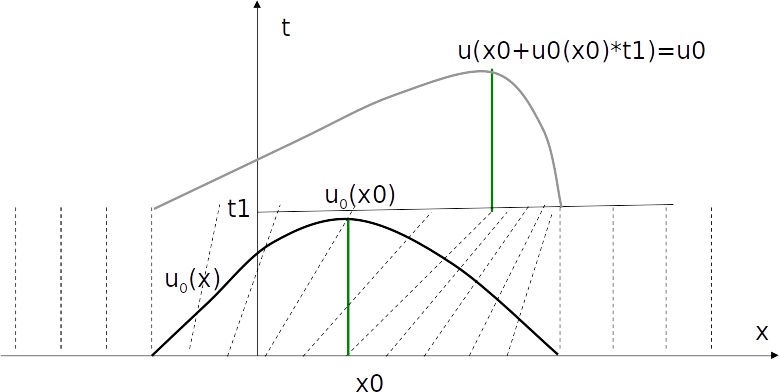

В обычном смысле уравнение ${\partial{u}\over {\partial t}}+{\partial{f}\over {\partial x}}=0$ допускает только непрерывные решения (более того дифференцируемые). Это приводит к тому, что для некоторых начальных данных решений может не существовать. Пример:

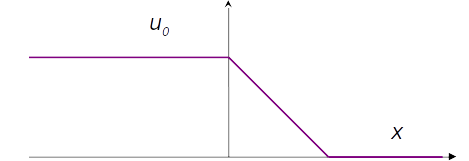

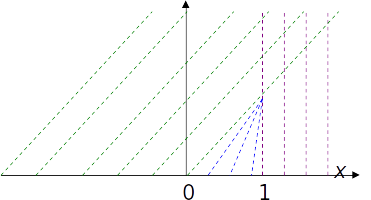

Решение (которое должно быть постоянным вдоль характеристик) является 
однозначным при t < 1 и многозначным при больших временах (следовательно, 
непрерывного решения не существует). Из этого примера видно, что подобная 
ситуация с пересекающимися характеристиками возникает только при убывающей
функции u0(x) (хотя бы локально), а при строго не убывающей начальной функции
характеристики расходятся и пересечений не возникает ни при каком t > 0.
В этом случае решение существует и единственно.

Для устранения проблемы допускается существование разрывных решений. Переход от дифференциальной к интегральной записи. Теория обобщенных функций.

Выводы из теории:

В области гладкого решения - исходное уравнение. На поверхности разрыва условия Ренкина-Гюгонио:

$$f(u_R) - f(u_L) = S(u_R-u_L)$$

где $S$ - скорость распространения разрыва, $u_R, u_L$ - состояния слева и справа от него

$$ S=\frac{f_R - f_L}{u_R - u_L} = \frac{\frac{1}{2} u_R^2 - \frac{1}{2} u_L^2}{u_R-u_L}= \frac{u_R+u_L}{2}$$

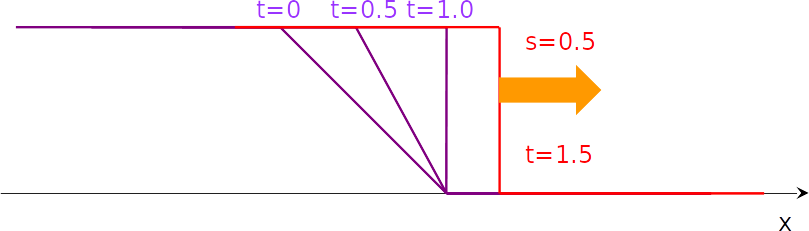

Плата за существование - неединственность решения!

${\partial{u}\over {\partial t}}+{\partial{u^2/2}\over {\partial x}}=0$ и ${\partial{u^2}\over {\partial t}}+{\partial{2u^3/3}\over {\partial x}}=0$ приводят к одному и тому же уравнению, но к разным скоростям распространения разрыва!

Рассмотрим другой вид разрыва.
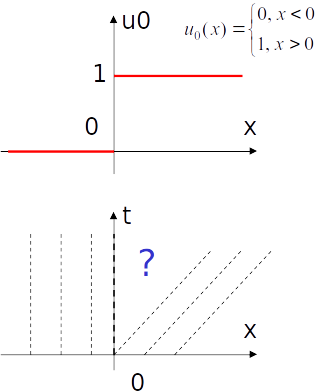
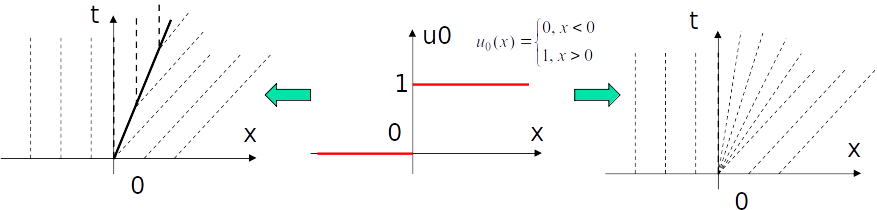

Решение - добавить вязкость к уравнению, посмотреть что получится в предельном случае.

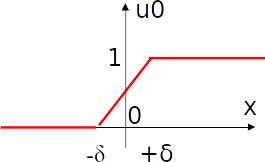
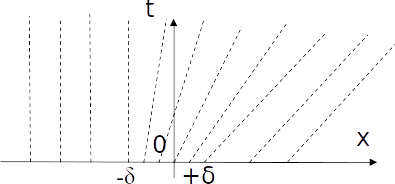
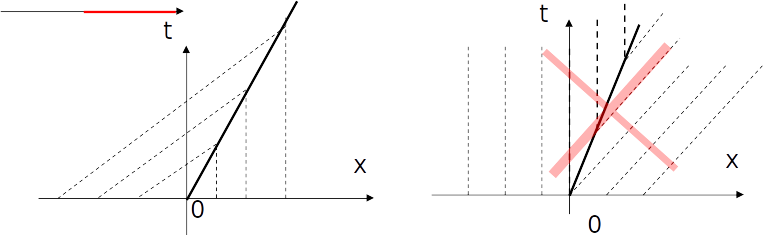

Не существует ударных волн разряжения! Энтропия возрастает.

## Заключение <a name="finish"></a>

1. [Конвекция OpenFOAM](#convection_of)
2. [Нелинейность](#nonlinear)

## В следующей серии ...

Нелинейность источникового слагаемого, ГУ, система уравнений Эйлера! 

<table><tr>
<td> <img src="img/gu.jpeg" width="500" height="200"> </td>
<td> <img src="img/ns.jpeg" width="400" height="200"> </td>
</tr></table>
